In [1]:
import os
import sys

from pathlib import Path


# si aggiunge al path la cartella utils per avere visibilità del module
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import timm
import torch
import numpy as np
import pandas as pd
import utils.datasets as build
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from tqdm import tqdm
from skimage import io
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
# serve per ricaricare il codice modificato
%load_ext autoreload
%autoreload 2

In [4]:
# configurazione
batch_size=32
lr=0.001
epochs=30
device="cuda"

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="fourier"

In [5]:
# directory da dove vengono prelevate le immagini
if mode == "rgb":
    path = Path(os.getcwd()).parent.parent

    fake_data_dir = os.path.join(path, "artifact", "taming_transformer")
    real_data_dir = os.path.join(path, "artifact", "coco")

else: 
    path = Path(os.getcwd()).parent
    fake_data_dir = os.path.join(path, "temp", "taming_transformer+coco", "train", "taming_transformer")
    real_data_dir = os.path.join(path, "temp", "taming_transformer+coco", "train", "coco")

In [6]:
# carica le immagini nel dataset
class ApnDataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if str(row.Anchor).startswith("coco"):
        a_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(real_data_dir, row.Positive))
        n_img = io.imread(os.path.join(fake_data_dir, row.Negative))

        a_label = 0
        p_label = 0
        n_label = 1

      else:
        a_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        n_img = io.imread(os.path.join(real_data_dir, row.Negative))

        a_label = 1
        p_label = 1
        n_label = 0

      # normalizzazione per immagini in rgb 
      a_img = torch.from_numpy(a_img).permute(2, 0, 1) / 255.0
      p_img = torch.from_numpy(p_img).permute(2, 0, 1) / 255.0
      n_img = torch.from_numpy(n_img).permute(2, 0, 1) / 255.0

      a_label = torch.tensor(a_label)
      p_label = torch.tensor(p_label)
      n_label = torch.tensor(n_label)

    if mode == "fourier":
      if "real" in row.Anchor:
        a_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(real_data_dir, row.Positive))
        n_img = io.imread(os.path.join(fake_data_dir, row.Negative))

        a_label = 0
        p_label = 0
        n_label = 1

      else:
        a_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        p_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        n_img = io.imread(os.path.join(real_data_dir, row.Negative))

        a_label = 1
        p_label = 1
        n_label = 0

      # normalizzazione immagini nello spettro di fourier
      a_img = np.expand_dims(a_img, 0)
      p_img = np.expand_dims(p_img, 0)
      n_img = np.expand_dims(n_img, 0)
      
      a_img = torch.from_numpy(a_img) / 255.0
      p_img = torch.from_numpy(p_img) / 255.0
      n_img = torch.from_numpy(n_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return a_img, p_img, n_img, a_label, p_label, n_label

In [7]:
# classe per caricare il modello di rete neurale direttamente dalle repository online
class ApnModel(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size=512):
    super(ApnModel, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [8]:
if mode == "rgb":
    df_out_path = os.path.join("..", "datasets", "out.csv")
    df_out = pd.read_csv(df_out_path)

else: 
    df_out_path = os.path.join("..", "datasets", "fourier_out.csv")
    df_out = pd.read_csv(df_out_path)

In [9]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  # on dropout 
  model.train()
  
  total_loss = 0.0

  for a, p, n, al, pl, nl in tqdm(dataloader, desc="model training..."):
    a, p, n = a.to(device), p.to(device), n.to(device)
    al, pl, nl = al.to(device), pl.to(device), nl.to(device)

    optimizer.zero_grad()

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    a_embs = model(a)
    p_embs = model(p)
    n_embs = model(n)

    # calcolo della loss
    loss = criterion(a_embs, p_embs, n_embs)
    
    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [10]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  # off dropout
  model.eval() 
  
  total_loss = 0.0

  with torch.no_grad():
    for a, p, n, al, pl, nl in tqdm(dataloader, desc="model validating..."):
      a, p, n = a.to(device), p.to(device), n.to(device)
      al, pl, nl = al.to(device), pl.to(device), nl.to(device)

      a_embs = model(a)
      p_embs = model(p)
      n_embs = model(n)
      
      loss = criterion(a_embs, p_embs, n_embs)
      
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [11]:
model = ApnModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "fourier":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(device);

In [12]:
# split del nuovo dataframe
train_df, valid_df = train_test_split(df_out, test_size=0.20, random_state=42)

trainset = ApnDataset(train_df)
validset = ApnDataset(valid_df)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [13]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []

for i in range(epochs):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...:   0%|          | 0/1250 [00:00<?, ?it/s]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
model validating...: 100%|██████████| 313/313 [07:57<00:00,  1.52s/it]


successful weights saving...
epochs: 1, train_loss: 0.7755754417181016, valid_loss: 0.6225451062472103


model validating...: 100%|██████████| 313/313 [06:48<00:00,  1.30s/it]


successful weights saving...
epochs: 2, train_loss: 0.5463717471957207, valid_loss: 0.5701893688486026


model validating...: 100%|██████████| 313/313 [05:44<00:00,  1.10s/it]


epochs: 3, train_loss: 0.5516989362239838, valid_loss: 0.61298157488957


model validating...: 100%|██████████| 313/313 [07:31<00:00,  1.44s/it]


successful weights saving...
epochs: 4, train_loss: 0.5357988654464483, valid_loss: 0.5278210314318014


model validating...: 100%|██████████| 313/313 [05:21<00:00,  1.03s/it]


epochs: 5, train_loss: 0.5485613367944956, valid_loss: 0.6027478516673128


model validating...: 100%|██████████| 313/313 [03:38<00:00,  1.43it/s]


successful weights saving...
epochs: 6, train_loss: 0.5313110380649567, valid_loss: 0.5260631135477426


model validating...: 100%|██████████| 313/313 [08:13<00:00,  1.58s/it]


epochs: 7, train_loss: 0.5119799234420062, valid_loss: 0.5262545445285285


model validating...: 100%|██████████| 313/313 [05:14<00:00,  1.00s/it]


epochs: 8, train_loss: 0.4849050430446863, valid_loss: 0.5516926513407558


model validating...: 100%|██████████| 313/313 [06:29<00:00,  1.24s/it]


successful weights saving...
epochs: 9, train_loss: 0.43281441524624825, valid_loss: 0.5000318495895916


model validating...: 100%|██████████| 313/313 [06:54<00:00,  1.32s/it]


epochs: 10, train_loss: 0.38334469460844994, valid_loss: 0.5236970597562699


model validating...: 100%|██████████| 313/313 [06:50<00:00,  1.31s/it]


epochs: 11, train_loss: 0.3870479468345642, valid_loss: 0.5004425616786122


model validating...: 100%|██████████| 313/313 [06:36<00:00,  1.27s/it]


successful weights saving...
epochs: 12, train_loss: 0.3685403817176819, valid_loss: 0.45110967193548673


model validating...: 100%|██████████| 313/313 [06:47<00:00,  1.30s/it]


epochs: 13, train_loss: 0.3550224334090948, valid_loss: 0.46545813368341793


model validating...: 100%|██████████| 313/313 [04:18<00:00,  1.21it/s]


epochs: 14, train_loss: 0.3501950291633606, valid_loss: 0.45793238129859537


model validating...: 100%|██████████| 313/313 [05:59<00:00,  1.15s/it]


epochs: 15, train_loss: 0.32986003240644934, valid_loss: 0.5368125356091097


model validating...: 100%|██████████| 313/313 [06:14<00:00,  1.19s/it]


epochs: 16, train_loss: 0.32959659167528155, valid_loss: 0.5056187584758186


model validating...: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


epochs: 17, train_loss: 0.3128245632499456, valid_loss: 0.45875401056993503


model validating...: 100%|██████████| 313/313 [06:49<00:00,  1.31s/it]


epochs: 18, train_loss: 0.309157557785511, valid_loss: 0.4566204751642367


model validating...: 100%|██████████| 313/313 [08:14<00:00,  1.58s/it]


successful weights saving...
epochs: 19, train_loss: 0.29582434216737746, valid_loss: 0.43618974165794566


model validating...: 100%|██████████| 313/313 [06:50<00:00,  1.31s/it]


successful weights saving...
epochs: 20, train_loss: 0.2794153170764446, valid_loss: 0.4332357614089887


model validating...: 100%|██████████| 313/313 [07:05<00:00,  1.36s/it]


successful weights saving...
epochs: 21, train_loss: 0.2902747651785612, valid_loss: 0.42797456391322347


model validating...: 100%|██████████| 313/313 [08:08<00:00,  1.56s/it]


successful weights saving...
epochs: 22, train_loss: 0.2757244954109192, valid_loss: 0.4254959769808827


model validating...: 100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


epochs: 23, train_loss: 0.27521176849901674, valid_loss: 0.4293325233835572


model validating...: 100%|██████████| 313/313 [01:40<00:00,  3.10it/s]


epochs: 24, train_loss: 0.26308199652433395, valid_loss: 0.43741094842315104


model validating...: 100%|██████████| 313/313 [01:45<00:00,  2.96it/s]


successful weights saving...
epochs: 25, train_loss: 0.26207284846305845, valid_loss: 0.4137311436640569


model validating...: 100%|██████████| 313/313 [07:24<00:00,  1.42s/it]


epochs: 26, train_loss: 0.2605733903467655, valid_loss: 0.43043361875576713


model validating...: 100%|██████████| 313/313 [01:41<00:00,  3.10it/s]


successful weights saving...
epochs: 27, train_loss: 0.258224267527461, valid_loss: 0.4131368500784563


model validating...: 100%|██████████| 313/313 [01:46<00:00,  2.93it/s]


successful weights saving...
epochs: 28, train_loss: 0.23299755456447602, valid_loss: 0.41125599216348446


model validating...: 100%|██████████| 313/313 [07:31<00:00,  1.44s/it]


epochs: 29, train_loss: 0.23207720737159251, valid_loss: 0.4216148712383673


model validating...: 100%|██████████| 313/313 [01:40<00:00,  3.10it/s]

successful weights saving...
epochs: 30, train_loss: 0.23225304053127765, valid_loss: 0.3973775496736121


<function matplotlib.pyplot.show(close=None, block=None)>

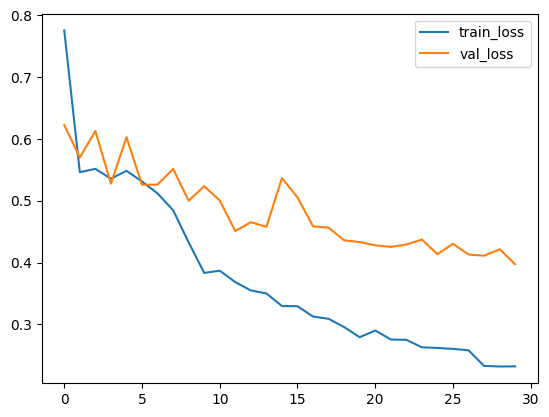

In [15]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [16]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dir_folder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr, desc="creating encodings..."):
      if mode == "rgb":
        if str(i).startswith("coco"):
          dir_folder = real_data_dir
        else: 
          dir_folder = fake_data_dir
        
        a = io.imread(os.path.join(dir_folder, i))
        a = torch.from_numpy(a).permute(2, 0, 1) / 255.0
      
      if mode == "fourier":
        if "real" in str(i):
          dir_folder = real_data_dir
        else: 
          dir_folder = fake_data_dir

        a = io.imread(os.path.join(dir_folder, i))
        a = np.expand_dims(a, 0)
        a = torch.from_numpy(a.astype(np.int32)) / 255.0
        
      a = a.to(device)
      a_enc = model(a.unsqueeze(0))
      encodings.append(a_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    anc_img_names_df = pd.DataFrame(anc_img_names_arr, columns=['Anchor'])
    df_enc = pd.concat([anc_img_names_df, encodings], axis=1)

    return df_enc

In [17]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati
df_enc = get_encoding_csv(model, df_out["Anchor"], real_data_dir)
df_enc.to_csv("database.csv", index=False)

creating encodings...: 100%|██████████| 50000/50000 [17:17<00:00, 48.19it/s]


In [18]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,0_anchor_real.png,0.095289,0.034589,-0.192240,-0.384247,5.694656,-0.288686,0.581914,-1.330046,0.499665,...,1.321592,0.466617,-0.324039,0.389728,0.430698,0.548914,-1.605643,0.142647,-0.510968,-0.116022
1,1_anchor_real.png,0.092172,0.036155,-0.190613,-0.381452,5.702983,-0.284906,0.581814,-1.327779,0.502419,...,1.329099,0.468646,-0.327799,0.389162,0.432083,0.548015,-1.608222,0.138681,-0.510310,-0.115095
2,2_anchor_real.png,0.086745,0.030028,-0.187307,-0.381979,5.665952,-0.289323,0.580224,-1.331515,0.498167,...,1.310974,0.471245,-0.324818,0.386884,0.428529,0.544862,-1.615100,0.140527,-0.505175,-0.110818
3,3_anchor_real.png,0.095616,0.024707,-0.192666,-0.384592,5.771955,-0.292832,0.580171,-1.328703,0.495844,...,1.307915,0.466088,-0.320728,0.389646,0.429491,0.550141,-1.621628,0.145957,-0.509814,-0.115121
4,4_anchor_real.png,0.095095,0.028297,-0.191966,-0.383148,5.715172,-0.291161,0.581376,-1.330439,0.496759,...,1.314386,0.465167,-0.321505,0.388427,0.431259,0.548013,-1.613937,0.142929,-0.509594,-0.115491


In [19]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [20]:
if mode == "rgb":
    fake_dataset_path = os.path.join(fake_data_dir, "metadata.csv")
    real_dataset_path = os.path.join(real_data_dir, "metadata.csv")

    test_df_path = os.path.join("..", "datasets", "testList.csv")
    build.test(fake_dataset_path, real_dataset_path, df_out, test_df_path)
    test_df = pd.read_csv(test_df_path)

else: 
    path = Path(os.getcwd()).parent
    fake_data_dir = os.path.join(path, "temp", "taming_transformer+coco", "test", "taming_transformer")
    real_data_dir = os.path.join(path, "temp", "taming_transformer+coco", "test", "coco")
    
    test_df_path = os.path.join("..", "datasets", "fourier_test_list.csv")
    test_df = pd.read_csv(test_df_path)

print(test_df["real"])
print(test_df.size)
test_df.head()

0          0_real.png
1          1_real.png
2          2_real.png
3          3_real.png
4          4_real.png
            ...      
1995    1995_real.png
1996    1996_real.png
1997    1997_real.png
1998    1998_real.png
1999    1999_real.png
Name: real, Length: 2000, dtype: object
4000


,real,fake
0,0_real.png,0_fake.png
1,1_real.png,1_fake.png
2,2_real.png,2_fake.png
3,3_real.png,3_fake.png
4,4_real.png,4_fake.png


In [21]:
def get_image_embeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "fourier":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [22]:
def search_in_database(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [23]:
y_true = []
y_pred = []

temp_df = test_df
temp_df.head()
temp_df.shape

(2000, 2)

In [24]:
# testo i fake
current_test = "fake"
database = df_enc

fake_images = temp_df[current_test].dropna()
print(len(fake_images))

# prendo i primi 500 Fake
for i in tqdm(fake_images, desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, i)
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model)
    closest_label = search_in_database(img_enc, database)
    
    if mode == "rgb":
        if str(closest_label).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")
    
    else: 
        if "real" in str(closest_label):
            y_pred.append("real")
        else:
            y_pred.append("fake")

1000


testing on fake images...: 100%|██████████| 1000/1000 [16:19<00:00,  1.02it/s]


In [25]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
1000
['fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 

In [26]:
# testo i real
current_test = "real"
database = df_enc

real_images = temp_df[current_test]
print(len(real_images))

for i in tqdm(real_images, desc="testing on real images..."):
    path = os.path.join(real_data_dir, i)
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model)
    closest_label = search_in_database(img_enc, database)
    
    if mode == "rgb":
        if str(closest_label).startswith("coco"):
            y_pred.append("real")
        else:
            y_pred.append("fake")
    
    else: 
        if "real" in str(closest_label):
            y_pred.append("real")
        else:
            y_pred.append("fake")

2000


testing on real images...: 100%|██████████| 2000/2000 [32:44<00:00,  1.02it/s]


In [27]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
3000
['fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 

In [28]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * len(temp_df["fake"].dropna()))
temp = np.array(["real"] * len(temp_df["real"]))
y_true = np.concatenate([y_true, temp])

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

[[1691  309]
 [ 156  844]]


In [29]:
tn, fp, fn, tp = cm.ravel()

# metriche
accuracy = round((tp + tn) / (tp + tn + fp + fn), 4) * 100
precision = round((tp) / (tp + fp), 4) * 100
recall = round((tp) / (tp + fn), 4) * 100
specificity = round((tn) / (tn + fp) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 84.5, 'Precision': 73.2, 'Recall': 84.39999999999999, 'Specificity': 84.55, 'F1 Score': 78.402}


In [30]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "fourier", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)